In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.utils.data import DataLoader, Subset
import copy

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
data_path = "/content/gdrive/MyDrive/MS 2nd Semester/AAV data/Images/175 mV/1s_segment_raw/train_val_photos"

In [ ]:
from torchvision import datasets

# Temporary loader to get class names
dataset = datasets.ImageFolder(data_path)
print(dataset.class_to_idx)

{'Double': 0, 'Empty': 1, 'Single': 2}


In [ ]:
# Set seed
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [ ]:
set_seed()

In [ ]:
# ---------- Data Loaders with Train/Test Split ----------
def get_dataloaders_from_single_dataset(root='', batch_size=32, labeled_fraction=0.2, test_size=0.2):
    transform_weak = T.Compose([
        T.RandomHorizontalFlip(),
        T.RandomResizedCrop(224),
        T.ToTensor()
    ])

    transform_strong = T.Compose([
        T.RandomHorizontalFlip(),
        T.RandomResizedCrop(224),
        T.ColorJitter(0.4, 0.4, 0.4, 0.1),
        T.RandomGrayscale(p=0.2),
        T.ToTensor()
    ])

    transform_test = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor()
    ])

    full_dataset = ImageFolder("/content/gdrive/MyDrive/MS 2nd Semester/AAV data/Images/175 mV/1s_segment_raw/train_val_photos")
    num_classes = len(full_dataset.classes)

    indices = list(range(len(full_dataset)))
    train_idx, test_idx = train_test_split(indices, test_size=test_size, stratify=[full_dataset.targets[i] for i in indices])

    # Further split train into labeled/unlabeled
    random.shuffle(train_idx)
    split = int(labeled_fraction * len(train_idx))
    labeled_idx = train_idx[:split]
    unlabeled_idx = train_idx[split:]

    labeled_dataset = Subset(copy.deepcopy(full_dataset), labeled_idx)
    unlabeled_dataset = Subset(copy.deepcopy(full_dataset), unlabeled_idx)
    test_dataset = Subset(copy.deepcopy(full_dataset), test_idx)

    labeled_dataset.dataset.transform = transform_weak
    unlabeled_dataset.dataset.transform = transform_strong
    test_dataset.dataset.transform = transform_test

    labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return labeled_loader, unlabeled_loader, test_loader, num_classes


In [ ]:
# ---------- Model ----------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.backbone = resnet18(pretrained=True)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

In [ ]:
# ---------- FixMatch Training ----------
def train_fixmatch(model, labeled_loader, unlabeled_loader, test_loader, epochs=20, threshold=0.95, lambda_u=1.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    train_losses, test_accuracies = [], []
    unlabeled_iter = iter(unlabeled_loader)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for (x_l, y_l) in labeled_loader:
            try:
                x_u, _ = next(unlabeled_iter)
            except StopIteration:
                unlabeled_iter = iter(unlabeled_loader)
                x_u, _ = next(unlabeled_iter)

            x_l, y_l, x_u = x_l.to(device), y_l.to(device), x_u.to(device)

            with torch.no_grad():
                logits_u_w = model(x_u)
                pseudo_labels = torch.softmax(logits_u_w, dim=-1)
                max_probs, targets_u = torch.max(pseudo_labels, dim=-1)
                mask = max_probs.ge(threshold).float()

            x_u_s = x_u  # already strongly augmented
            logits_l = model(x_l)
            logits_u_s = model(x_u_s)

            loss_l = criterion(logits_l, y_l)
            loss_u = (F.cross_entropy(logits_u_s, targets_u, reduction='none') * mask).mean()

            loss = loss_l + lambda_u * loss_u
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_losses.append(total_loss / len(labeled_loader))
        acc, f1 = evaluate(model, test_loader, device)
        test_accuracies.append(acc)

        print(f"[Epoch {epoch+1}] Loss: {total_loss:.4f} | Test Acc: {acc:.2f}% | F1: {f1:.4f}")

    return model, train_losses, test_accuracies

In [ ]:
# ---------- Evaluation ----------
def evaluate(model, dataloader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            outputs = model(x)
            preds = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    acc = 100.0 * np.mean(np.array(y_true) == np.array(y_pred))
    f1 = f1_score(y_true, y_pred, average='weighted')
    return acc, f1

In [ ]:
# ---------- ROC Curve ----------
def plot_roc_curve(model, dataloader, device, num_classes):
    model.eval()
    y_true, y_prob = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            output = model(x)
            probs = torch.softmax(output, dim=1)
            y_prob.extend(probs.cpu().numpy())
            y_true.extend(y.numpy())
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)

    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve per Class")
    plt.legend()
    plt.grid()
    plt.show()


In [ ]:
# ---------- Loss & Accuracy Curve ----------
def plot_training_curves(train_losses, test_accuracies):
    epochs = len(train_losses)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label="Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), test_accuracies, label="Test Accuracy", color='orange')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Test Accuracy")
    plt.grid()
    plt.show()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 130MB/s]


[Epoch 1] Loss: 14.1144 | Test Acc: 31.87% | F1: 0.2393
[Epoch 2] Loss: 9.1897 | Test Acc: 25.09% | F1: 0.1599
[Epoch 3] Loss: 8.5886 | Test Acc: 79.67% | F1: 0.7960
[Epoch 4] Loss: 7.2465 | Test Acc: 69.78% | F1: 0.6634
[Epoch 5] Loss: 9.4254 | Test Acc: 60.99% | F1: 0.5519
[Epoch 6] Loss: 7.7082 | Test Acc: 75.09% | F1: 0.7366
[Epoch 7] Loss: 7.5821 | Test Acc: 50.00% | F1: 0.3888
[Epoch 8] Loss: 7.0923 | Test Acc: 43.04% | F1: 0.2713
[Epoch 9] Loss: 8.3932 | Test Acc: 44.87% | F1: 0.3171
[Epoch 10] Loss: 7.0038 | Test Acc: 69.78% | F1: 0.6660
[Epoch 11] Loss: 7.6815 | Test Acc: 60.26% | F1: 0.5634
[Epoch 12] Loss: 6.9660 | Test Acc: 63.37% | F1: 0.6027
[Epoch 13] Loss: 6.0303 | Test Acc: 43.96% | F1: 0.2847
[Epoch 14] Loss: 6.3807 | Test Acc: 42.31% | F1: 0.2652
[Epoch 15] Loss: 6.5206 | Test Acc: 42.49% | F1: 0.2544
[Epoch 16] Loss: 7.9462 | Test Acc: 42.12% | F1: 0.2519
[Epoch 17] Loss: 7.1265 | Test Acc: 42.12% | F1: 0.2550
[Epoch 18] Loss: 6.1803 | Test Acc: 47.07% | F1: 0.3551


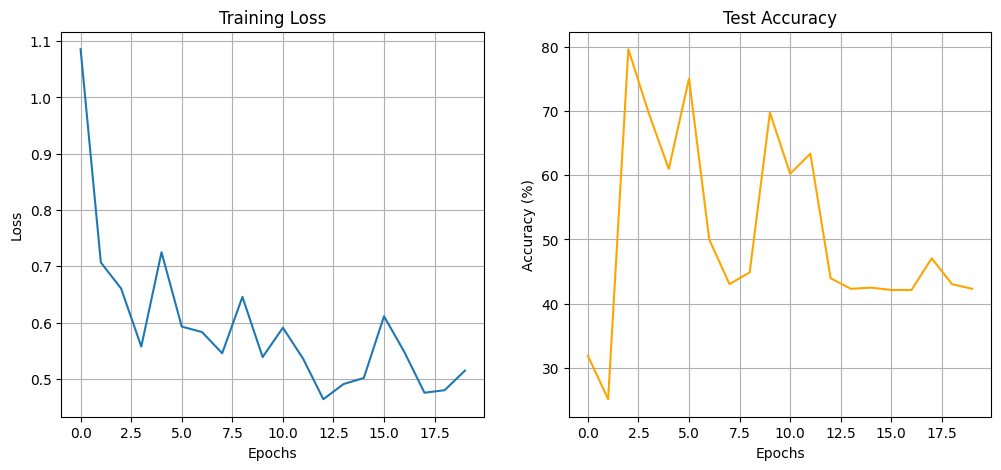

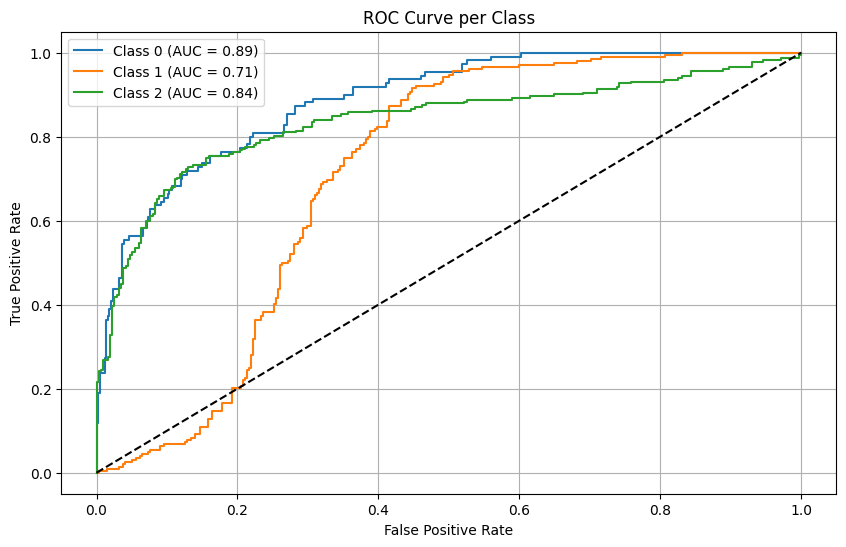

In [ ]:
# ---------- Main ----------
if __name__ == "__main__":
    labeled_loader, unlabeled_loader, test_loader, num_classes = get_dataloaders_from_single_dataset(root="/")
    model = SimpleCNN(num_classes=num_classes)
    model, losses, accs = train_fixmatch(model, labeled_loader, unlabeled_loader, test_loader)
    plot_training_curves(losses, accs)
    plot_roc_curve(model, test_loader, torch.device("cuda" if torch.cuda.is_available() else "cpu"), num_classes=num_classes)


In [ ]:
!pip uninstall torch torchvision -y
!pip install torch==1.13.1+cu116 torchvision==0.14.1+cu116 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
!pip install torchvision

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 134MB/s]


[Epoch 1] Loss: 14.1224 | Test Acc: 46.15% | F1: 0.3951
[Epoch 2] Loss: 9.0703 | Test Acc: 34.07% | F1: 0.2838
[Epoch 3] Loss: 8.1131 | Test Acc: 73.99% | F1: 0.7201
[Epoch 4] Loss: 6.8475 | Test Acc: 47.62% | F1: 0.3563
[Epoch 5] Loss: 9.1308 | Test Acc: 48.72% | F1: 0.3877
[Epoch 6] Loss: 7.6455 | Test Acc: 50.92% | F1: 0.4060
[Epoch 7] Loss: 7.2975 | Test Acc: 42.67% | F1: 0.2707
[Epoch 8] Loss: 7.6988 | Test Acc: 56.96% | F1: 0.5270
[Epoch 9] Loss: 8.3712 | Test Acc: 45.05% | F1: 0.3350
[Epoch 10] Loss: 7.2131 | Test Acc: 46.52% | F1: 0.3544
[Epoch 11] Loss: 7.5260 | Test Acc: 55.49% | F1: 0.4757
[Epoch 12] Loss: 6.7422 | Test Acc: 75.09% | F1: 0.7439
[Epoch 13] Loss: 6.1239 | Test Acc: 43.04% | F1: 0.2797
[Epoch 14] Loss: 6.2126 | Test Acc: 42.12% | F1: 0.2611
[Epoch 15] Loss: 5.8916 | Test Acc: 43.04% | F1: 0.2652
[Epoch 16] Loss: 7.4809 | Test Acc: 48.35% | F1: 0.3919
[Epoch 17] Loss: 6.6859 | Test Acc: 47.25% | F1: 0.3651
[Epoch 18] Loss: 6.5729 | Test Acc: 43.22% | F1: 0.2851


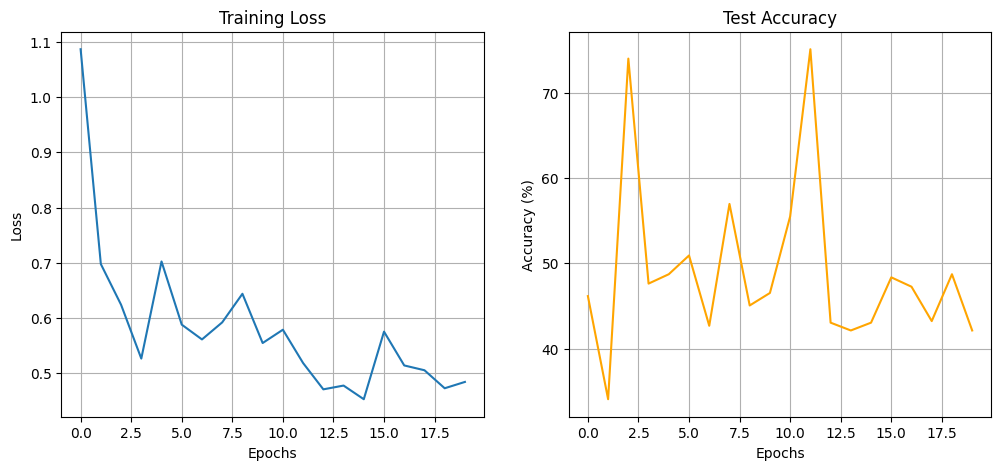


Classification Report:
              precision    recall  f1-score   support

      Double       0.00      0.00      0.00       110
       Empty       0.20      0.00      0.01       204
      Single       0.42      0.99      0.59       232

    accuracy                           0.42       546
   macro avg       0.21      0.33      0.20       546
weighted avg       0.25      0.42      0.26       546



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


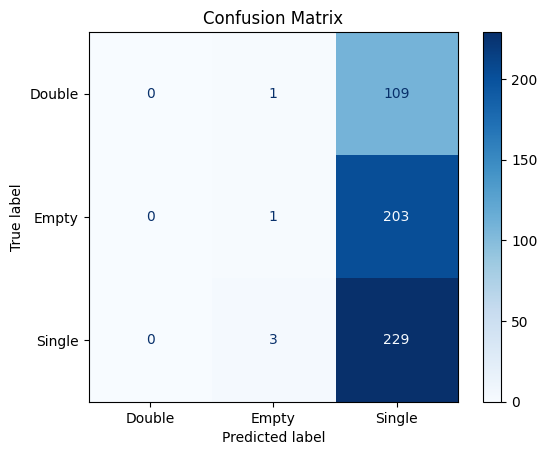

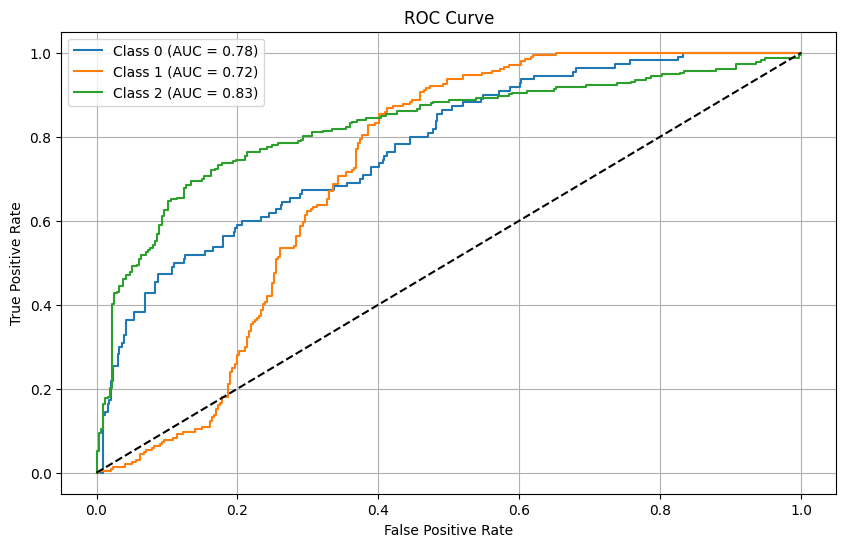

In [ ]:
import os
import torch
import torch.nn as nn
import requests
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T # Corrected import
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.utils.data import DataLoader, Subset
import copy

# Set seed
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

# ---------- Data Loaders ----------
def get_dataloaders_from_single_dataset(root, batch_size=32, labeled_fraction=0.2, test_size=0.2):
    transform_weak = T.Compose([
        T.RandomHorizontalFlip(),
        T.RandomResizedCrop(224),
        T.ToTensor()
    ])

    transform_strong = T.Compose([
        T.RandomHorizontalFlip(),
        T.RandomResizedCrop(224),
        T.ColorJitter(0.4, 0.4, 0.4, 0.1),
        T.RandomGrayscale(p=0.2),
        T.ToTensor()
    ])

    transform_test = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor()
    ])

    full_dataset = ImageFolder("/content/gdrive/MyDrive/MS 2nd Semester/AAV data/Images/175 mV/1s_segment_raw/train_val_photos")
    num_classes = len(full_dataset.classes)

    indices = list(range(len(full_dataset)))
    train_idx, test_idx = train_test_split(indices, test_size=test_size,
                                           stratify=[full_dataset.targets[i] for i in indices])

    random.shuffle(train_idx)
    split = int(labeled_fraction * len(train_idx))
    labeled_idx = train_idx[:split]
    unlabeled_idx = train_idx[split:]

    labeled_dataset = Subset(copy.deepcopy(full_dataset), labeled_idx)
    unlabeled_dataset = Subset(copy.deepcopy(full_dataset), unlabeled_idx)
    test_dataset = Subset(copy.deepcopy(full_dataset), test_idx)

    labeled_dataset.dataset.transform = transform_weak
    unlabeled_dataset.dataset.transform = transform_strong
    test_dataset.dataset.transform = transform_test

    labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return labeled_loader, unlabeled_loader, test_loader, num_classes, full_dataset.classes

# ---------- Model ----------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.backbone = resnet18(pretrained=True)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

# ---------- Training ----------
def train_fixmatch(model, labeled_loader, unlabeled_loader, test_loader, epochs=20, threshold=0.95, lambda_u=1.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    train_losses, test_accuracies = [], []
    unlabeled_iter = iter(unlabeled_loader)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for (x_l, y_l) in labeled_loader:
            try:
                x_u, _ = next(unlabeled_iter)
            except StopIteration:
                unlabeled_iter = iter(unlabeled_loader)
                x_u, _ = next(unlabeled_iter)

            x_l, y_l, x_u = x_l.to(device), y_l.to(device), x_u.to(device)

            with torch.no_grad():
                logits_u_w = model(x_u)
                pseudo_labels = torch.softmax(logits_u_w, dim=-1)
                max_probs, targets_u = torch.max(pseudo_labels, dim=-1)
                mask = max_probs.ge(threshold).float()

            logits_l = model(x_l)
            logits_u_s = model(x_u)

            loss_l = criterion(logits_l, y_l)
            loss_u = (F.cross_entropy(logits_u_s, targets_u, reduction='none') * mask).mean()

            loss = loss_l + lambda_u * loss_u
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_losses.append(total_loss / len(labeled_loader))
        acc, f1, _, _ = evaluate(model, test_loader, device)
        test_accuracies.append(acc)

        print(f"[Epoch {epoch+1}] Loss: {total_loss:.4f} | Test Acc: {acc:.2f}% | F1: {f1:.4f}")

    return model, train_losses, test_accuracies

# ---------- Evaluation ----------
def evaluate(model, dataloader, device):
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            outputs = model(x)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())
    acc = 100.0 * np.mean(np.array(y_true) == np.array(y_pred))
    f1 = f1_score(y_true, y_pred, average='weighted')
    return acc, f1, y_true, y_pred

# ---------- ROC Curve ----------
def plot_roc_curve(y_true, y_probs, num_classes):
    y_true = np.array(y_true)
    y_probs = np.array(y_probs)
    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid()
    plt.show()

# ---------- Confusion Matrix ----------
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# ---------- Training Curves ----------
def plot_training_curves(train_losses, test_accuracies):
    epochs = len(train_losses)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label="Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), test_accuracies, label="Test Accuracy", color='orange')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Test Accuracy")
    plt.grid()
    plt.show()

# ---------- Main ----------
if __name__ == "__main__":
    root_dir = "/content/gdrive/MyDrive/MS 2nd Semester/AAV data/Images/175 mV/1s_segment_raw/train_val_photos"
    labeled_loader, unlabeled_loader, test_loader, num_classes, class_names = get_dataloaders_from_single_dataset(root=root_dir)

    model = SimpleCNN(num_classes=num_classes)
    model, losses, accs = train_fixmatch(model, labeled_loader, unlabeled_loader, test_loader)

    plot_training_curves(losses, accs)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    _, _, y_true, y_pred = evaluate(model, test_loader, device)

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    plot_confusion_matrix(y_true, y_pred, class_names)

    with torch.no_grad():
        y_probs = []
        for x, _ in test_loader:
            x = x.to(device)
            output = model(x)
            probs = torch.softmax(output, dim=1)
            y_probs.extend(probs.cpu().numpy())
        plot_roc_curve(y_true, y_probs, num_classes)

In [ ]:
# After training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluate on test set
test_acc, test_f1, y_true_test, y_pred_test = evaluate(model, test_loader, device)
print(f"\nTest Accuracy: {test_acc:.2f}%")
print(f"Test F1 Score: {test_f1:.4f}")

# For validation: split a portion from labeled data
val_size = int(0.2 * len(labeled_loader.dataset))
train_size = len(labeled_loader.dataset) - val_size
train_subset, val_subset = torch.utils.data.random_split(labeled_loader.dataset, [train_size, val_size])

val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
val_acc, val_f1, y_true_val, y_pred_val = evaluate(model, val_loader, device)
print(f"\nValidation Accuracy: {val_acc:.2f}%")
print(f"Validation F1 Score: {val_f1:.4f}")



Test Accuracy: 42.12%
Test F1 Score: 0.2553

Validation Accuracy: 44.83%
Validation F1 Score: 0.3616



======= Running FixMatch with Threshold=0.8 =======
Epoch 1: Loss=12.9729 | Val Acc=26.09%
Epoch 2: Loss=8.1033 | Val Acc=57.67%
Epoch 3: Loss=7.4841 | Val Acc=56.75%
Epoch 4: Loss=7.5486 | Val Acc=48.97%
Epoch 5: Loss=5.9436 | Val Acc=44.16%
Epoch 6: Loss=6.7608 | Val Acc=50.34%
Epoch 7: Loss=6.4273 | Val Acc=64.99%
Epoch 8: Loss=5.7738 | Val Acc=59.50%
Epoch 9: Loss=5.9617 | Val Acc=45.31%
Epoch 10: Loss=5.9884 | Val Acc=42.56%
Epoch 11: Loss=6.1830 | Val Acc=47.83%
Epoch 12: Loss=6.0672 | Val Acc=41.88%
Epoch 13: Loss=5.9325 | Val Acc=42.11%
Epoch 14: Loss=5.9666 | Val Acc=42.11%
Epoch 15: Loss=4.7062 | Val Acc=41.88%
Epoch 16: Loss=6.4288 | Val Acc=41.88%
Epoch 17: Loss=5.5673 | Val Acc=42.11%
Epoch 18: Loss=5.7763 | Val Acc=45.77%
Epoch 19: Loss=5.2182 | Val Acc=54.23%
Epoch 20: Loss=4.9160 | Val Acc=42.11%


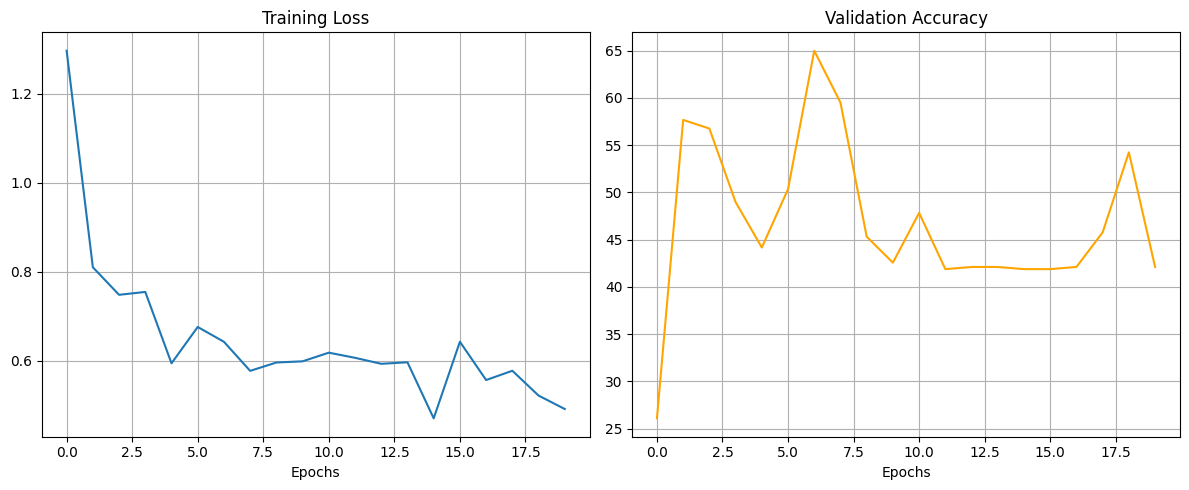

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Evaluation @ Threshold=0.8
Accuracy: 42.12% | Precision: 0.2729 | Recall: 0.4212 | F1: 0.2550


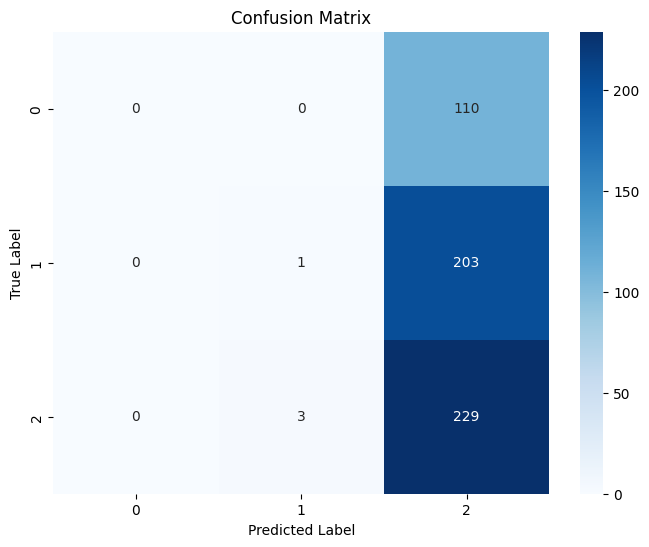

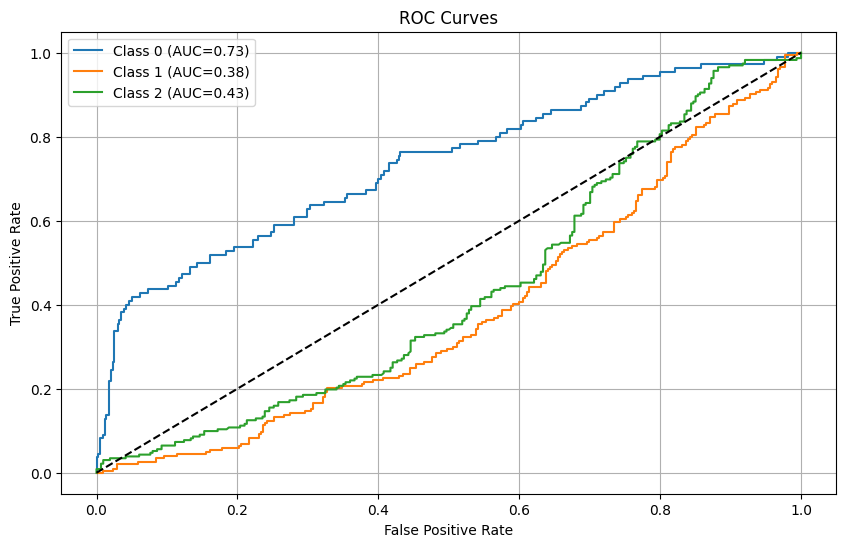


======= Running FixMatch with Threshold=0.9 =======


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Loss=11.2851 | Val Acc=61.56%
Epoch 2: Loss=8.5762 | Val Acc=61.56%
Epoch 3: Loss=7.0245 | Val Acc=60.87%
Epoch 4: Loss=6.7634 | Val Acc=48.97%
Epoch 5: Loss=6.3459 | Val Acc=44.39%
Epoch 6: Loss=5.9426 | Val Acc=51.72%
Epoch 7: Loss=6.7652 | Val Acc=64.53%
Epoch 8: Loss=5.6968 | Val Acc=49.20%
Epoch 9: Loss=5.1687 | Val Acc=60.64%
Epoch 10: Loss=5.2888 | Val Acc=45.31%
Epoch 11: Loss=5.5848 | Val Acc=49.66%
Epoch 12: Loss=5.6861 | Val Acc=43.71%
Epoch 13: Loss=4.8643 | Val Acc=43.02%
Epoch 14: Loss=5.3448 | Val Acc=44.85%
Epoch 15: Loss=4.4899 | Val Acc=45.31%
Epoch 16: Loss=4.8105 | Val Acc=53.55%
Epoch 17: Loss=6.0053 | Val Acc=56.98%
Epoch 18: Loss=4.9655 | Val Acc=42.33%
Epoch 19: Loss=5.1113 | Val Acc=42.56%
Epoch 20: Loss=4.7802 | Val Acc=43.02%


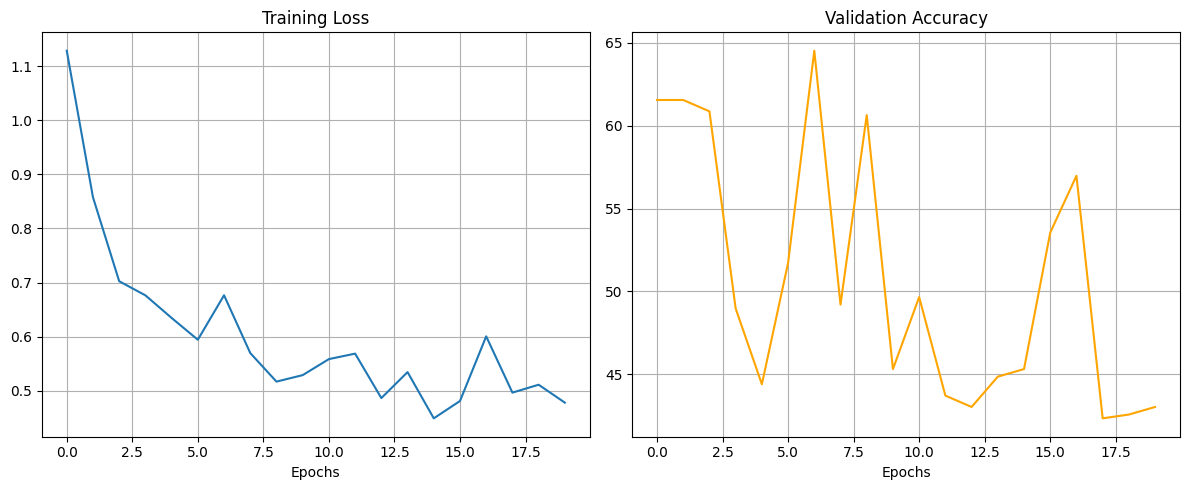


Evaluation @ Threshold=0.9
Accuracy: 42.86% | Precision: 0.4477 | Recall: 0.4286 | F1: 0.2704


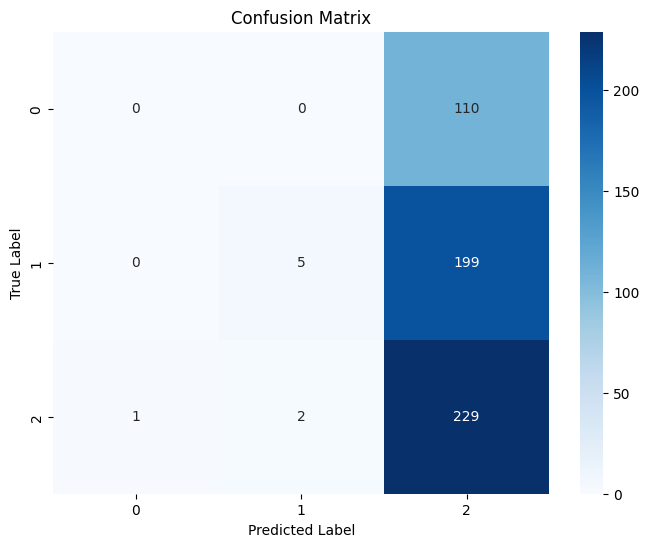

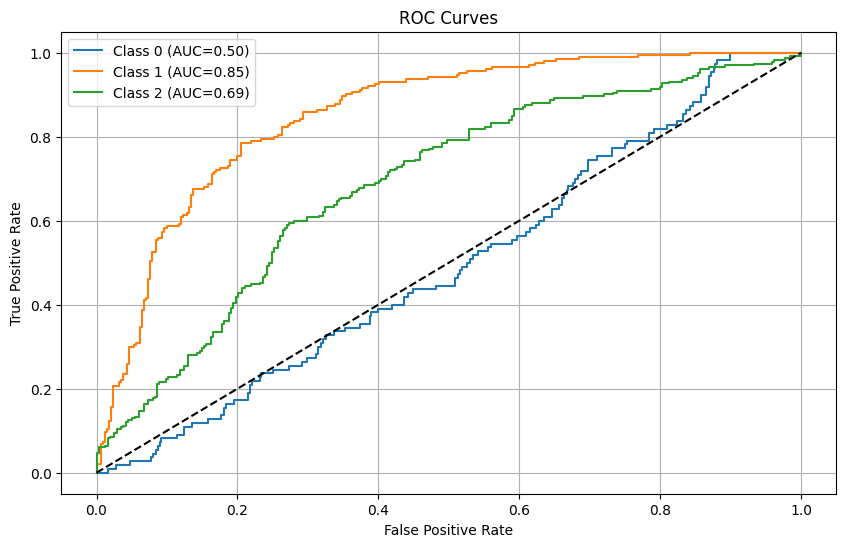


======= Running FixMatch with Threshold=0.95 =======


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Loss=12.1668 | Val Acc=63.84%
Epoch 2: Loss=7.7108 | Val Acc=74.60%
Epoch 3: Loss=7.9045 | Val Acc=64.76%
Epoch 4: Loss=6.4686 | Val Acc=68.88%
Epoch 5: Loss=5.7749 | Val Acc=73.91%
Epoch 6: Loss=6.2180 | Val Acc=76.20%
Epoch 7: Loss=5.1876 | Val Acc=60.41%
Epoch 8: Loss=4.8193 | Val Acc=67.28%
Epoch 9: Loss=5.9944 | Val Acc=42.79%
Epoch 10: Loss=5.2904 | Val Acc=73.46%
Epoch 11: Loss=5.9483 | Val Acc=46.68%
Epoch 12: Loss=5.8356 | Val Acc=62.47%
Epoch 13: Loss=5.2145 | Val Acc=52.86%
Epoch 14: Loss=4.5990 | Val Acc=84.67%
Epoch 15: Loss=5.1254 | Val Acc=48.74%
Epoch 16: Loss=4.3726 | Val Acc=55.15%
Epoch 17: Loss=4.8498 | Val Acc=54.92%
Epoch 18: Loss=4.7494 | Val Acc=48.74%
Epoch 19: Loss=5.0665 | Val Acc=47.83%
Epoch 20: Loss=4.4609 | Val Acc=59.04%


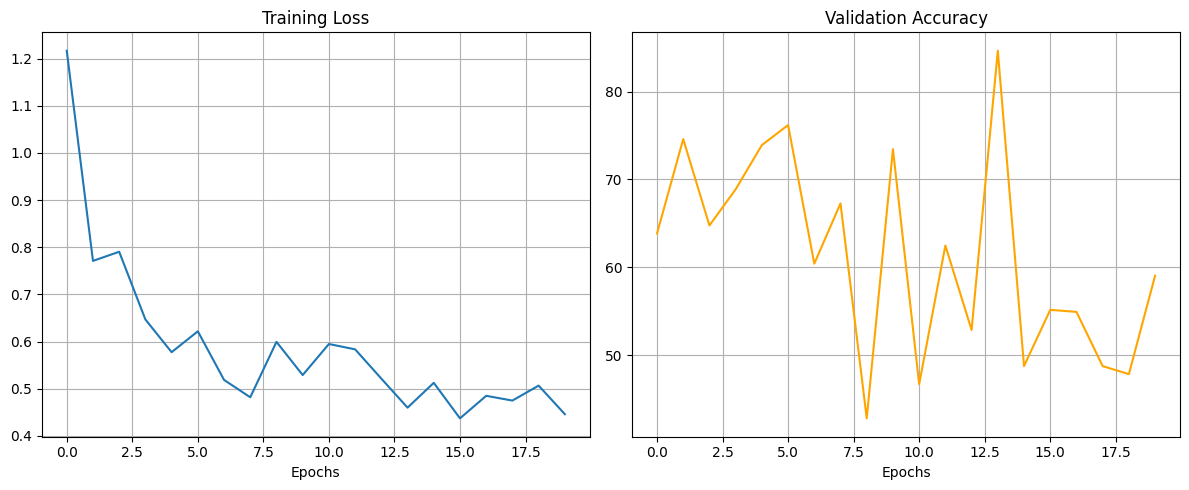

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Evaluation @ Threshold=0.95
Accuracy: 60.07% | Precision: 0.4780 | Recall: 0.6007 | F1: 0.5228


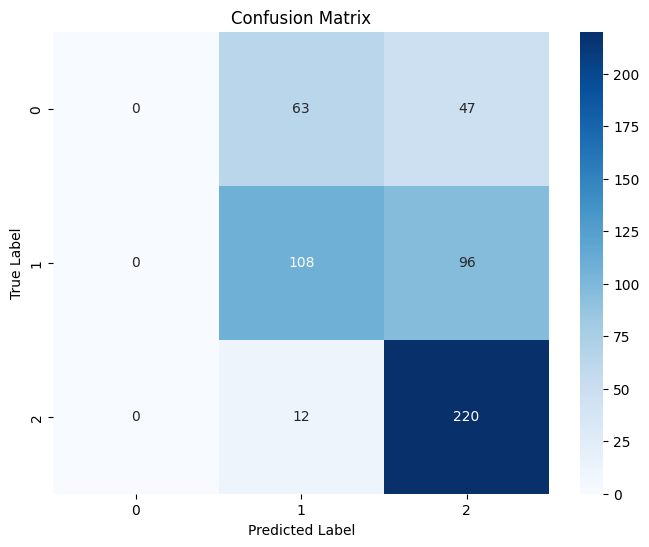

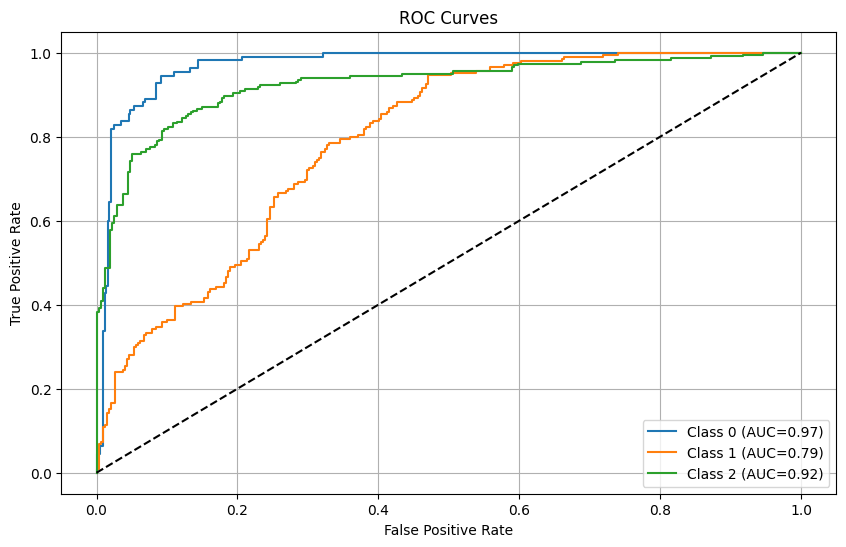

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, roc_curve, auc,
                             f1_score, precision_score, recall_score, accuracy_score)
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.utils.data import DataLoader, Subset
import seaborn as sns
import copy

# Set random seed
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

def get_dataloaders(root, batch_size=32, labeled_fraction=0.2, val_size=0.2, test_size=0.2,
                    weak_aug=True, strong_aug=True):
    # Transformations
    transform_weak = T.Compose([
        T.RandomHorizontalFlip(),
        T.RandomResizedCrop(224),
        T.ToTensor()
    ])

    transform_strong = T.Compose([
        T.RandomHorizontalFlip(),
        T.RandomResizedCrop(224),
        T.ColorJitter(0.4, 0.4, 0.4, 0.1),
        T.RandomGrayscale(p=0.2),
        T.ToTensor()
    ])

    transform_test = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor()
    ])

    full_dataset = ImageFolder(root)
    num_classes = len(full_dataset.classes)
    indices = list(range(len(full_dataset)))

    trainval_idx, test_idx = train_test_split(indices, test_size=test_size, stratify=[full_dataset.targets[i] for i in indices])
    train_idx, val_idx = train_test_split(trainval_idx, test_size=val_size, stratify=[full_dataset.targets[i] for i in trainval_idx])

    split = int(labeled_fraction * len(train_idx))
    random.shuffle(train_idx)
    labeled_idx = train_idx[:split]
    unlabeled_idx = train_idx[split:]

    labeled_dataset = Subset(copy.deepcopy(full_dataset), labeled_idx)
    unlabeled_dataset = Subset(copy.deepcopy(full_dataset), unlabeled_idx)
    val_dataset = Subset(copy.deepcopy(full_dataset), val_idx)
    test_dataset = Subset(copy.deepcopy(full_dataset), test_idx)

    labeled_dataset.dataset.transform = transform_weak if weak_aug else transform_test
    unlabeled_dataset.dataset.transform = transform_strong if strong_aug else transform_test
    val_dataset.dataset.transform = transform_test
    test_dataset.dataset.transform = transform_test

    labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return labeled_loader, unlabeled_loader, val_loader, test_loader, num_classes

class FixMatchModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = resnet18(pretrained=True)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

def train_fixmatch(model, labeled_loader, unlabeled_loader, val_loader,
                   epochs=10, threshold=0.95, lambda_u=1.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    unlabeled_iter = iter(unlabeled_loader)
    train_losses, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for x_l, y_l in labeled_loader:
            try:
                x_u, _ = next(unlabeled_iter)
            except StopIteration:
                unlabeled_iter = iter(unlabeled_loader)
                x_u, _ = next(unlabeled_iter)

            x_l, y_l, x_u = x_l.to(device), y_l.to(device), x_u.to(device)
            with torch.no_grad():
                pseudo_outputs = model(x_u)
                pseudo_probs = torch.softmax(pseudo_outputs, dim=-1)
                max_probs, pseudo_labels = torch.max(pseudo_probs, dim=-1)
                mask = (max_probs >= threshold).float()

            logits_l = model(x_l)
            logits_u = model(x_u)

            loss_l = criterion(logits_l, y_l)
            loss_u = (F.cross_entropy(logits_u, pseudo_labels, reduction='none') * mask).mean()

            loss = loss_l + lambda_u * loss_u

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        train_losses.append(total_loss / len(labeled_loader))
        val_acc, _ = evaluate(model, val_loader, device)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}: Loss={total_loss:.4f} | Val Acc={val_acc:.2f}%")

    return model, train_losses, val_accuracies

def evaluate(model, dataloader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            outputs = model(x)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred) * 100
    f1 = f1_score(y_true, y_pred, average='weighted')
    return acc, f1

def full_metrics(model, dataloader, device, num_classes):
    model.eval()
    y_true, y_pred, y_scores = [], [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            output = model(x)
            probs = torch.softmax(output, dim=1)
            preds = torch.argmax(probs, dim=1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_scores = np.array(y_scores)

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    return acc, precision, recall, f1, cm, fpr, tpr, roc_auc

def plot_metrics(train_losses, val_accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.title("Training Loss")
    plt.xlabel("Epochs")
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
    plt.title("Validation Accuracy")
    plt.xlabel("Epochs")
    plt.grid()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title("Confusion Matrix")
    plt.show()

def plot_roc_curves(fpr, tpr, roc_auc, num_classes):
    plt.figure(figsize=(10, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC={roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend()
    plt.grid()
    plt.show()

if __name__ == '__main__':
    ROOT_PATH = "/content/gdrive/MyDrive/MS 2nd Semester/AAV data/Images/175 mV/1s_segment_raw/train_val_photos"
    BATCH_SIZE = 32
    LABEL_FRAC = 0.2
    EPOCHS = 20
    THRESHOLDS = [0.80, 0.90, 0.95]

    for thresh in THRESHOLDS:
        print(f"\n======= Running FixMatch with Threshold={thresh} =======")
        loaders = get_dataloaders(ROOT_PATH, batch_size=BATCH_SIZE, labeled_fraction=LABEL_FRAC)
        labeled_loader, unlabeled_loader, val_loader, test_loader, num_classes = loaders

        model = FixMatchModel(num_classes)
        model, losses, val_accs = train_fixmatch(model, labeled_loader, unlabeled_loader, val_loader,
                                                 epochs=EPOCHS, threshold=thresh)

        plot_metrics(losses, val_accs)

        acc, prec, rec, f1, cm, fpr, tpr, roc_auc = full_metrics(model, test_loader,
                                                                 torch.device("cuda" if torch.cuda.is_available() else "cpu"),
                                                                 num_classes)

        print(f"\nEvaluation @ Threshold={thresh}")
        print(f"Accuracy: {acc*100:.2f}% | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
        plot_confusion_matrix(cm, [str(i) for i in range(num_classes)])
        plot_roc_curves(fpr, tpr, roc_auc, num_classes)



===== Training MixMatch | Aug: none | Labeled Fraction: 0.2 =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Epoch 1] MixMatch Loss: 0.5806
[Epoch 2] MixMatch Loss: 0.7894
[Epoch 3] MixMatch Loss: 0.8930
[Epoch 4] MixMatch Loss: 0.5215
[Epoch 5] MixMatch Loss: 0.7553

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.75      0.85       110
           1       0.76      0.84      0.80       204
           2       0.81      0.83      0.82       232

    accuracy                           0.82       546
   macro avg       0.85      0.80      0.82       546
weighted avg       0.83      0.82      0.82       546


Confusion Matrix:
[[ 82  16  12]
 [  0 171  33]
 [  1  39 192]]

ROC AUC Score: 0.9501


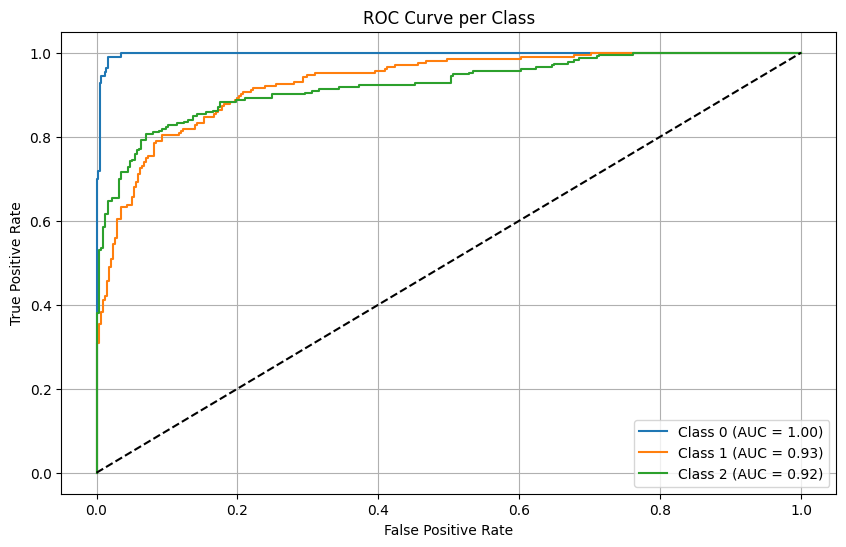


===== Training MixMatch | Aug: none | Labeled Fraction: 0.5 =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Epoch 1] MixMatch Loss: 0.5853
[Epoch 2] MixMatch Loss: 0.8903
[Epoch 3] MixMatch Loss: 0.2548
[Epoch 4] MixMatch Loss: 0.2772
[Epoch 5] MixMatch Loss: 0.7745

Classification Report:
              precision    recall  f1-score   support

           0       0.76      1.00      0.87       110
           1       0.87      0.79      0.83       204
           2       0.90      0.83      0.86       232

    accuracy                           0.85       546
   macro avg       0.84      0.88      0.85       546
weighted avg       0.86      0.85      0.85       546


Confusion Matrix:
[[110   0   0]
 [ 20 162  22]
 [ 14  25 193]]

ROC AUC Score: 0.9732


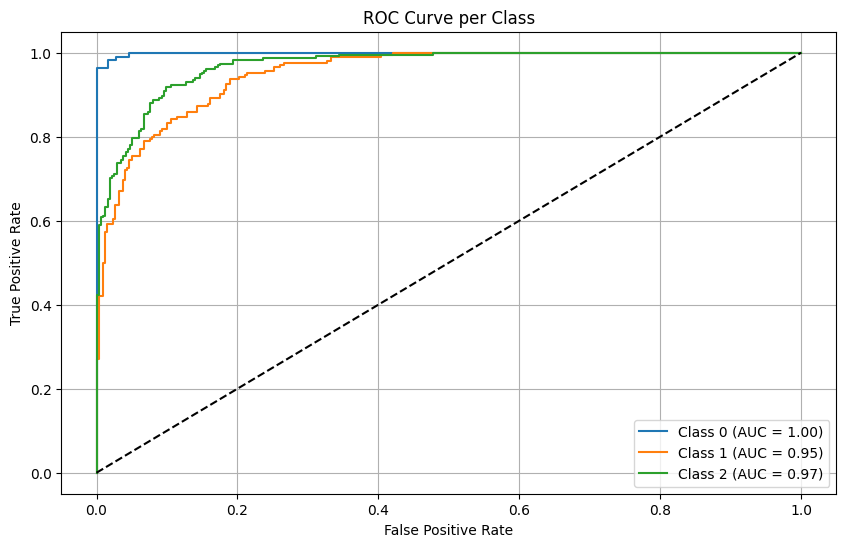


===== Training MixMatch | Aug: none | Labeled Fraction: 0.8 =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Epoch 1] MixMatch Loss: 0.7630
[Epoch 2] MixMatch Loss: 0.7490
[Epoch 3] MixMatch Loss: 0.4382
[Epoch 4] MixMatch Loss: 0.3979
[Epoch 5] MixMatch Loss: 0.5049

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98       110
           1       0.99      0.68      0.81       204
           2       0.77      1.00      0.87       232

    accuracy                           0.87       546
   macro avg       0.92      0.88      0.88       546
weighted avg       0.90      0.87      0.87       546


Confusion Matrix:
[[105   0   5]
 [  0 139  65]
 [  0   1 231]]

ROC AUC Score: 0.9871


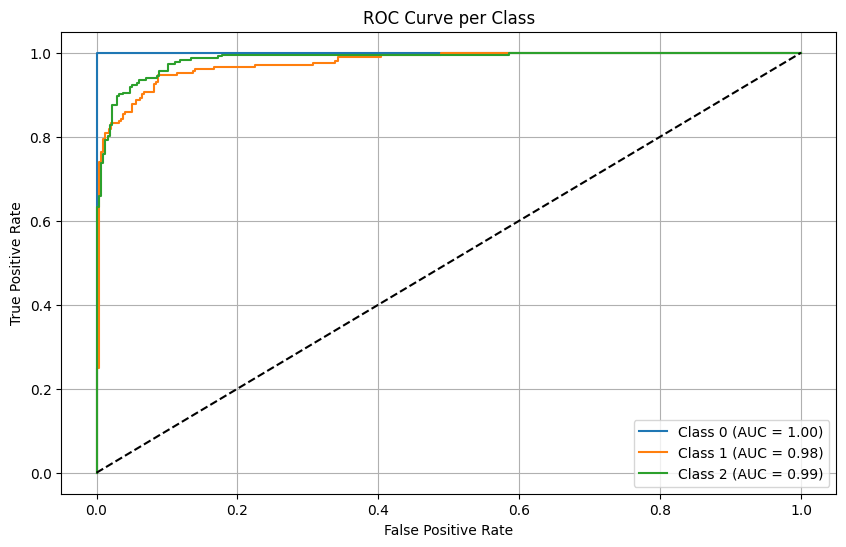


===== Training MixMatch | Aug: weak | Labeled Fraction: 0.2 =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Epoch 1] MixMatch Loss: 0.7833
[Epoch 2] MixMatch Loss: 0.9656
[Epoch 3] MixMatch Loss: 0.7876
[Epoch 4] MixMatch Loss: 0.8285
[Epoch 5] MixMatch Loss: 0.7912

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       110
           1       0.91      0.21      0.34       204
           2       0.60      0.96      0.73       232

    accuracy                           0.68       546
   macro avg       0.78      0.71      0.65       546
weighted avg       0.76      0.68      0.62       546


Confusion Matrix:
[[106   0   4]
 [ 15  42 147]
 [  6   4 222]]

ROC AUC Score: 0.9301


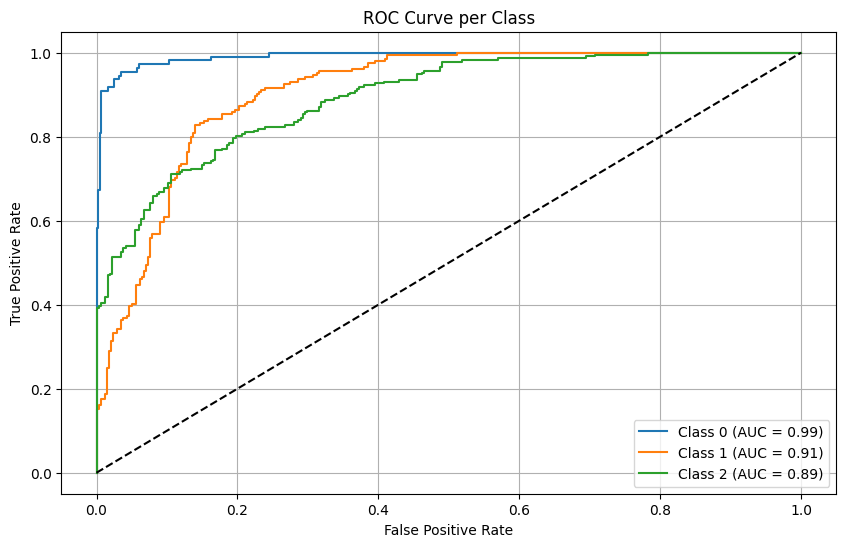


===== Training MixMatch | Aug: weak | Labeled Fraction: 0.5 =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Epoch 1] MixMatch Loss: 0.9226
[Epoch 2] MixMatch Loss: 0.7483
[Epoch 3] MixMatch Loss: 0.8537
[Epoch 4] MixMatch Loss: 0.6157
[Epoch 5] MixMatch Loss: 0.4660

Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       110
           1       0.94      0.65      0.77       204
           2       0.83      0.95      0.88       232

    accuracy                           0.85       546
   macro avg       0.85      0.87      0.84       546
weighted avg       0.86      0.85      0.84       546


Confusion Matrix:
[[110   0   0]
 [ 26 132  46]
 [  3   9 220]]

ROC AUC Score: 0.9743


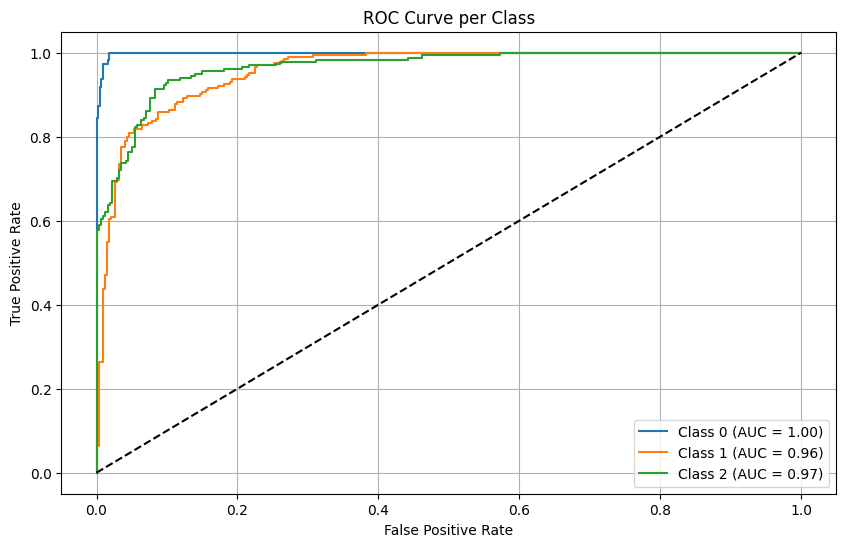


===== Training MixMatch | Aug: weak | Labeled Fraction: 0.8 =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Epoch 1] MixMatch Loss: 0.7545
[Epoch 2] MixMatch Loss: 0.6241
[Epoch 3] MixMatch Loss: 0.5884
[Epoch 4] MixMatch Loss: 0.4597
[Epoch 5] MixMatch Loss: 0.7266

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       110
           1       0.98      0.58      0.73       204
           2       0.74      0.97      0.84       232

    accuracy                           0.83       546
   macro avg       0.88      0.85      0.84       546
weighted avg       0.86      0.83      0.82       546


Confusion Matrix:
[[108   0   2]
 [  7 119  78]
 [  3   3 226]]

ROC AUC Score: 0.9761


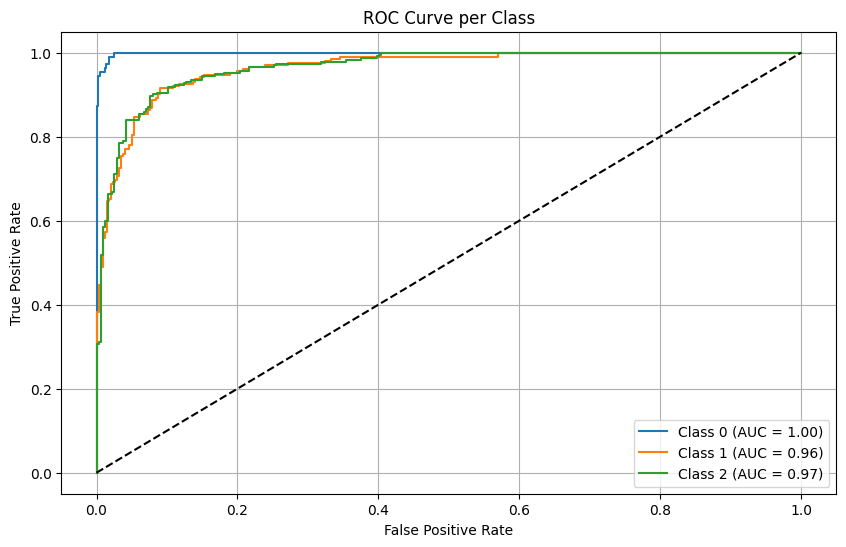


===== Training MixMatch | Aug: strong | Labeled Fraction: 0.2 =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Epoch 1] MixMatch Loss: 0.8385
[Epoch 2] MixMatch Loss: 0.9354
[Epoch 3] MixMatch Loss: 0.7325
[Epoch 4] MixMatch Loss: 0.8056
[Epoch 5] MixMatch Loss: 0.8974

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.91      0.74       110
           1       0.61      0.47      0.53       204
           2       0.58      0.57      0.57       232

    accuracy                           0.60       546
   macro avg       0.60      0.65      0.61       546
weighted avg       0.60      0.60      0.59       546


Confusion Matrix:
[[100   3   7]
 [ 19  95  90]
 [ 42  58 132]]

ROC AUC Score: 0.8158


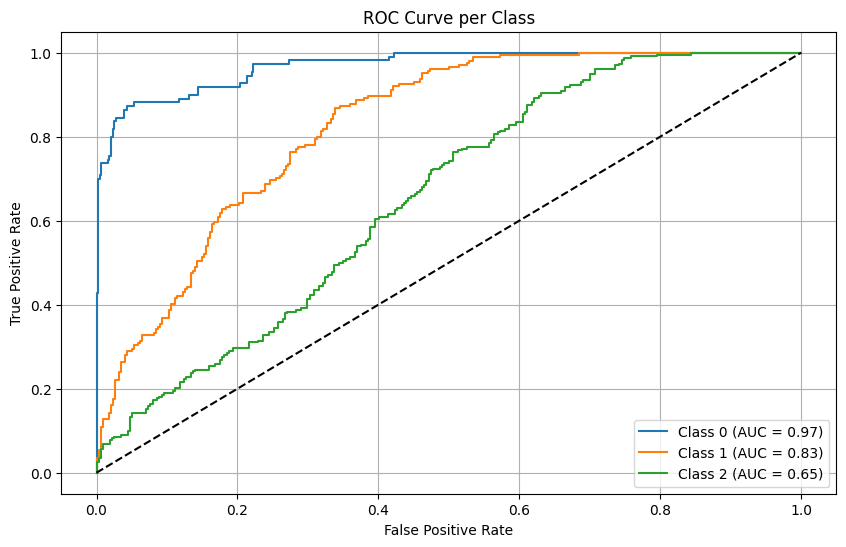


===== Training MixMatch | Aug: strong | Labeled Fraction: 0.5 =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Epoch 1] MixMatch Loss: 0.7844
[Epoch 2] MixMatch Loss: 0.8569
[Epoch 3] MixMatch Loss: 0.8889
[Epoch 4] MixMatch Loss: 0.6352
[Epoch 5] MixMatch Loss: 0.6125

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       110
           1       0.67      0.88      0.76       204
           2       0.90      0.58      0.71       232

    accuracy                           0.78       546
   macro avg       0.81      0.82      0.80       546
weighted avg       0.81      0.78      0.77       546


Confusion Matrix:
[[110   0   0]
 [  9 180  15]
 [  9  88 135]]

ROC AUC Score: 0.9429


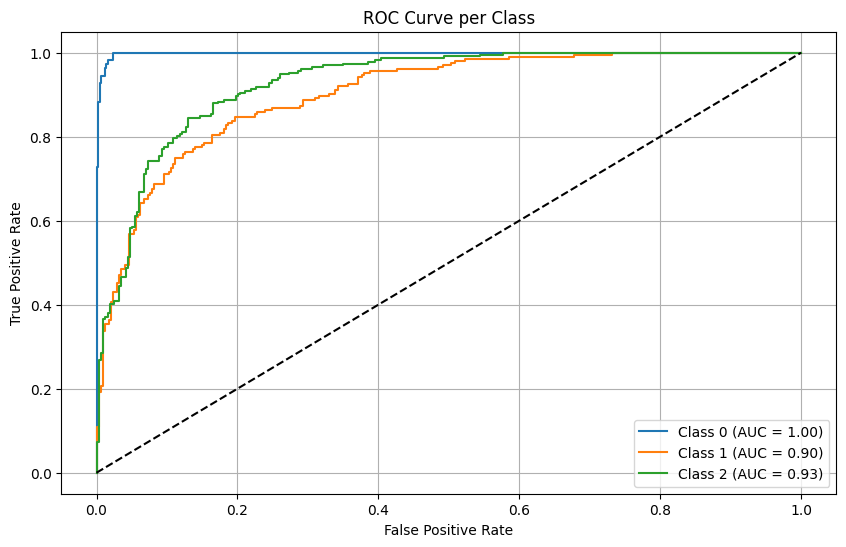


===== Training MixMatch | Aug: strong | Labeled Fraction: 0.8 =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Epoch 1] MixMatch Loss: 0.8699
[Epoch 2] MixMatch Loss: 0.8348
[Epoch 3] MixMatch Loss: 0.8431
[Epoch 4] MixMatch Loss: 0.7611
[Epoch 5] MixMatch Loss: 0.5315

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.90       110
           1       0.88      0.64      0.74       204
           2       0.72      0.94      0.81       232

    accuracy                           0.81       546
   macro avg       0.86      0.81      0.82       546
weighted avg       0.83      0.81      0.81       546


Confusion Matrix:
[[ 93   5  12]
 [  1 131  72]
 [  2  13 217]]

ROC AUC Score: 0.9508


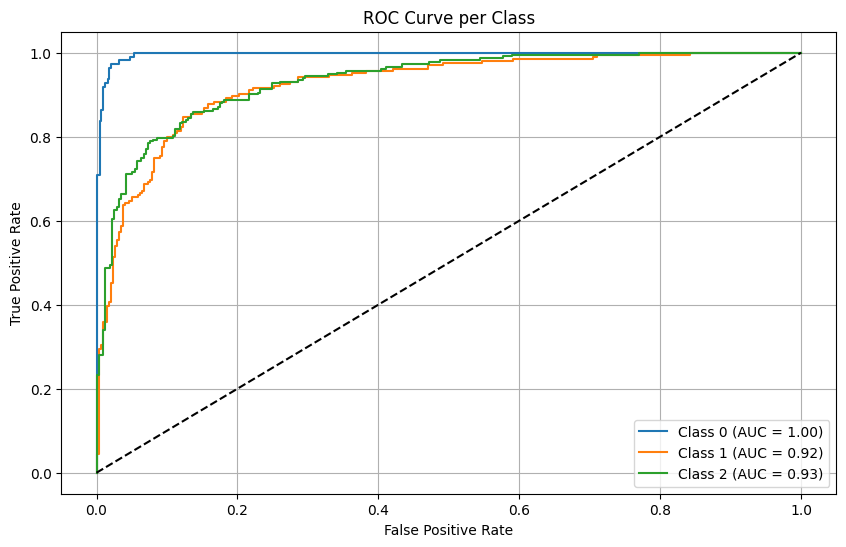

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from torch.utils.data import DataLoader, Subset, ConcatDataset
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import random
import copy

# ----- Setup -----
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- Model -----
class SimpleResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = resnet18(pretrained=True)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

# ----- Data Augmentations -----
def get_transforms(aug_type):
    if aug_type == 'strong':
        return T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomResizedCrop(224),
            T.ColorJitter(0.4, 0.4, 0.4, 0.1),
            T.RandomGrayscale(p=0.2),
            T.ToTensor()
        ])
    elif aug_type == 'weak':
        return T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomResizedCrop(224),
            T.ToTensor()
        ])
    else:  # 'none'
        return T.Compose([
            T.Resize((224, 224)),
            T.ToTensor()
        ])

# ----- Data Loaders -----
def get_mixmatch_dataloaders(data_path, batch_size, aug_type='weak', labeled_fraction=0.2, test_size=0.2):
    base_transform = get_transforms(aug_type)

    full_dataset = ImageFolder(data_path)
    num_classes = len(full_dataset.classes)

    indices = list(range(len(full_dataset)))
    targets = [full_dataset.targets[i] for i in indices]
    train_idx, test_idx = train_test_split(indices, test_size=test_size, stratify=targets)

    split = int(labeled_fraction * len(train_idx))
    random.shuffle(train_idx)
    labeled_idx = train_idx[:split]
    unlabeled_idx = train_idx[split:]

    labeled_dataset = Subset(copy.deepcopy(full_dataset), labeled_idx)
    unlabeled_dataset = Subset(copy.deepcopy(full_dataset), unlabeled_idx)
    test_dataset = Subset(copy.deepcopy(full_dataset), test_idx)

    labeled_dataset.dataset.transform = base_transform
    unlabeled_dataset.dataset.transform = base_transform
    test_dataset.dataset.transform = get_transforms('none')

    labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return labeled_loader, unlabeled_loader, test_loader, num_classes

# ----- MixMatch Loss -----
def sharpen(p, T=0.5):
    p = p ** (1 / T)
    return p / p.sum(dim=1, keepdim=True)

def mixup(x, y, alpha=0.75):
    l = np.random.beta(alpha, alpha)
    l = max(l, 1 - l)
    index = torch.randperm(x.size(0))
    mixed_x = l * x + (1 - l) * x[index]
    mixed_y = l * y + (1 - l) * y[index]
    return mixed_x, mixed_y

# ----- Training MixMatch -----
def train_mixmatch(model, labeled_loader, unlabeled_loader, test_loader, num_classes, epochs=5, lambda_u=75):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    criterion = nn.CrossEntropyLoss()
    unlabeled_iter = iter(unlabeled_loader)

    for epoch in range(epochs):
        model.train()
        for (x_l, y_l) in labeled_loader:
            try:
                x_u, _ = next(unlabeled_iter)
            except StopIteration:
                unlabeled_iter = iter(unlabeled_loader)
                x_u, _ = next(unlabeled_iter)

            x_l, y_l, x_u = x_l.to(device), y_l.to(device), x_u.to(device)

            with torch.no_grad():
                logits_u = model(x_u)
                pseudo_labels = torch.softmax(logits_u, dim=-1)
                pseudo_labels = sharpen(pseudo_labels)

            x_all = torch.cat([x_l, x_u], dim=0)
            y_all = torch.cat([
                F.one_hot(y_l, num_classes=num_classes).float(),
                pseudo_labels
            ], dim=0)

            mixed_x, mixed_y = mixup(x_all, y_all)
            logits = model(mixed_x)
            loss = -(mixed_y * F.log_softmax(logits, dim=1)).sum(dim=1).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"[Epoch {epoch+1}] MixMatch Loss: {loss.item():.4f}")

    evaluate(model, test_loader, num_classes)

# ----- Evaluation -----
def evaluate(model, dataloader, num_classes):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            logits = model(x)
            probs = torch.softmax(logits, dim=1)
            preds = probs.argmax(dim=1).cpu().numpy()
            y_true.extend(y.numpy())
            y_pred.extend(preds)
            y_prob.extend(probs.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    try:
        roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr')
        print(f"\nROC AUC Score: {roc_auc:.4f}")
    except:
        print("ROC AUC could not be calculated.")

    # ROC Curve
    y_true_bin = np.eye(num_classes)[y_true]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], np.array(y_prob)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve per Class")
    plt.legend()
    plt.grid()
    plt.show()

# ----- Main Execution -----
if __name__ == '__main__':
    data_path = "/content/gdrive/MyDrive/MS 2nd Semester/AAV data/Images/175 mV/1s_segment_raw/train_val_photos"
    batch_size = 32
    epochs = 5

    from itertools import product
    augmentations = ['none', 'weak', 'strong']
    fractions = [0.2, 0.5, 0.8]
    combinations = list(product(augmentations, fractions))


    for aug_type, labeled_fraction in combinations:
        print(f"\n===== Training MixMatch | Aug: {aug_type} | Labeled Fraction: {labeled_fraction} =====")
        labeled_loader, unlabeled_loader, test_loader, num_classes = get_mixmatch_dataloaders(
            data_path, batch_size, aug_type, labeled_fraction)
        model = SimpleResNet(num_classes=num_classes)
        train_mixmatch(model, labeled_loader, unlabeled_loader, test_loader, num_classes, epochs=epochs)



===== FixMatch | Aug: none | Labeled Fraction: 0.05 | Epochs: 5 =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Epoch 1] Loss: 0.8833 (L=0.8833, U=0.0000)
[Epoch 2] Loss: 0.3660 (L=0.2640, U=0.1020)
[Epoch 3] Loss: 0.2482 (L=0.0776, U=0.1706)
[Epoch 4] Loss: 0.5733 (L=0.0298, U=0.5436)
[Epoch 5] Loss: 0.2370 (L=0.0261, U=0.2110)

Classification Report:
              precision    recall  f1-score   support

           0     0.4183    1.0000    0.5898       110
           1     0.7041    0.6765    0.6900       204
           2     0.9080    0.3405    0.4953       232

    accuracy                         0.5989       546
   macro avg     0.6768    0.6723    0.5917       546
weighted avg     0.7332    0.5989    0.5871       546


Confusion Matrix:
[[110   0   0]
 [ 58 138   8]
 [ 95  58  79]]

ROC AUC Score: 0.8970


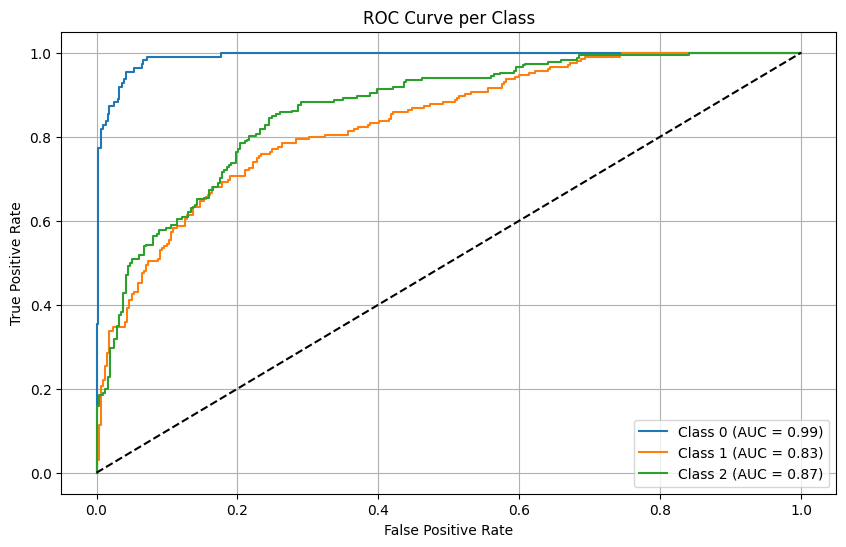


===== FixMatch | Aug: none | Labeled Fraction: 0.1 | Epochs: 5 =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Epoch 1] Loss: 0.5755 (L=0.5429, U=0.0326)
[Epoch 2] Loss: 0.5543 (L=0.4056, U=0.1487)
[Epoch 3] Loss: 0.3868 (L=0.1223, U=0.2645)
[Epoch 4] Loss: 0.4424 (L=0.0760, U=0.3663)
[Epoch 5] Loss: 0.1782 (L=0.1156, U=0.0625)

Classification Report:
              precision    recall  f1-score   support

           0     0.8800    0.8000    0.8381       110
           1     0.5216    0.9461    0.6725       204
           2     0.9605    0.3147    0.4740       232

    accuracy                         0.6484       546
   macro avg     0.7874    0.6869    0.6615       546
weighted avg     0.7803    0.6484    0.6215       546


Confusion Matrix:
[[ 88  22   0]
 [  8 193   3]
 [  4 155  73]]

ROC AUC Score: 0.9279


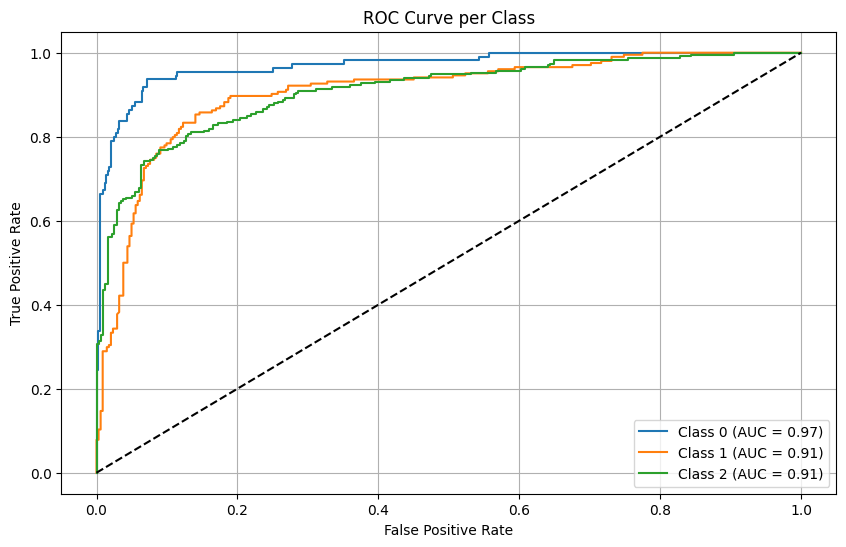


===== FixMatch | Aug: none | Labeled Fraction: 0.2 | Epochs: 5 =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Epoch 1] Loss: 0.7078 (L=0.4509, U=0.2569)
[Epoch 2] Loss: 0.4428 (L=0.3198, U=0.1230)
[Epoch 3] Loss: 1.0600 (L=0.4203, U=0.6397)
[Epoch 4] Loss: 0.4926 (L=0.1820, U=0.3105)
[Epoch 5] Loss: 0.2868 (L=0.0850, U=0.2018)

Classification Report:
              precision    recall  f1-score   support

           0     0.9304    0.9727    0.9511       110
           1     0.9116    0.6569    0.7635       204
           2     0.7641    0.9353    0.8411       232

    accuracy                         0.8388       546
   macro avg     0.8687    0.8550    0.8519       546
weighted avg     0.8527    0.8388    0.8343       546


Confusion Matrix:
[[107   0   3]
 [  6 134  64]
 [  2  13 217]]

ROC AUC Score: 0.9683


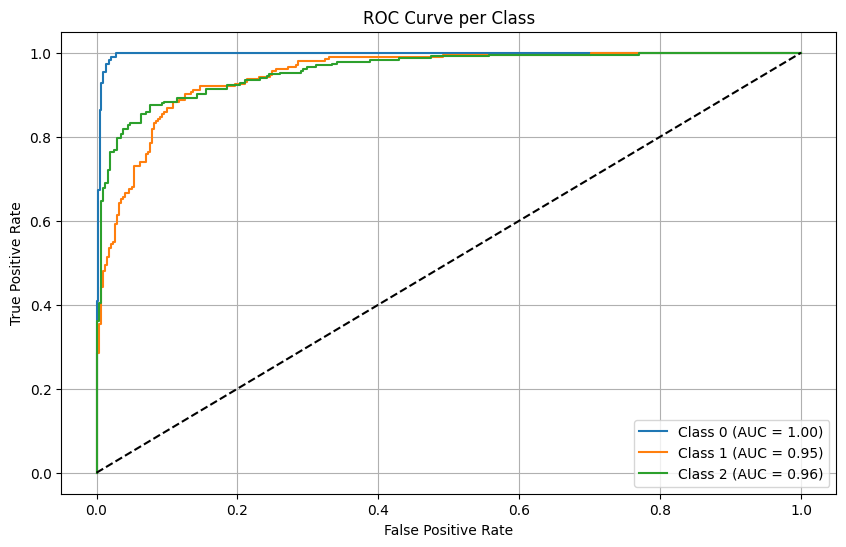


===== FixMatch | Aug: none | Labeled Fraction: 0.4 | Epochs: 5 =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Epoch 1] Loss: 0.5986 (L=0.4696, U=0.1290)
[Epoch 2] Loss: 0.1683 (L=0.0801, U=0.0882)
[Epoch 3] Loss: 0.6651 (L=0.1734, U=0.4917)
[Epoch 4] Loss: 0.3155 (L=0.1099, U=0.2055)
[Epoch 5] Loss: 0.3515 (L=0.3099, U=0.0417)

Classification Report:
              precision    recall  f1-score   support

           0     0.8088    1.0000    0.8943       110
           1     0.9900    0.4853    0.6513       204
           2     0.7290    0.9741    0.8339       232

    accuracy                         0.7967       546
   macro avg     0.8426    0.8198    0.7932       546
weighted avg     0.8426    0.7967    0.7779       546


Confusion Matrix:
[[110   0   0]
 [ 21  99  84]
 [  5   1 226]]

ROC AUC Score: 0.9739


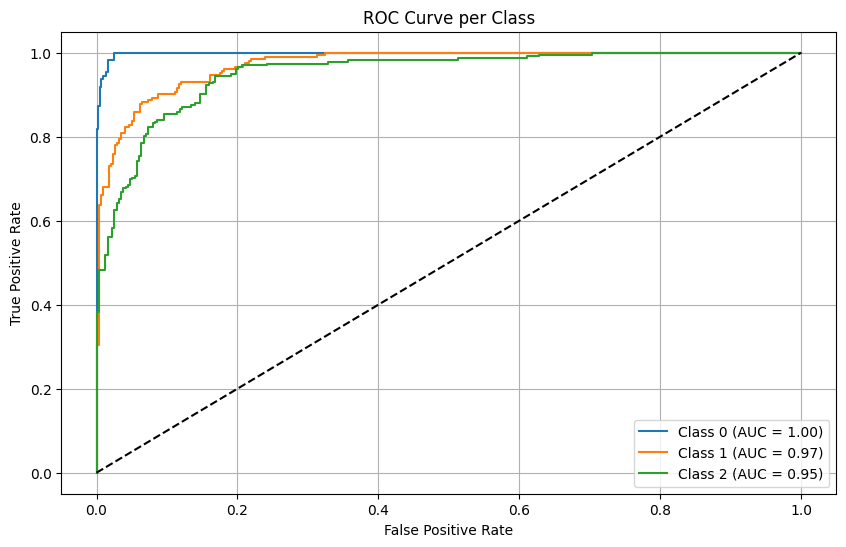


===== FixMatch | Aug: none | Labeled Fraction: 0.6 | Epochs: 5 =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Epoch 1] Loss: 0.3698 (L=0.2371, U=0.1327)
[Epoch 2] Loss: 0.2916 (L=0.2317, U=0.0599)
[Epoch 3] Loss: 0.4332 (L=0.3878, U=0.0454)
[Epoch 4] Loss: 0.3328 (L=0.1416, U=0.1912)
[Epoch 5] Loss: 0.2142 (L=0.1325, U=0.0816)

Classification Report:
              precision    recall  f1-score   support

           0     0.9636    0.9636    0.9636       110
           1     0.9630    0.5098    0.6667       204
           2     0.6890    0.9741    0.8071       232

    accuracy                         0.7985       546
   macro avg     0.8719    0.8159    0.8125       546
weighted avg     0.8467    0.7985    0.7862       546


Confusion Matrix:
[[106   0   4]
 [  2 104  98]
 [  2   4 226]]

ROC AUC Score: 0.9768


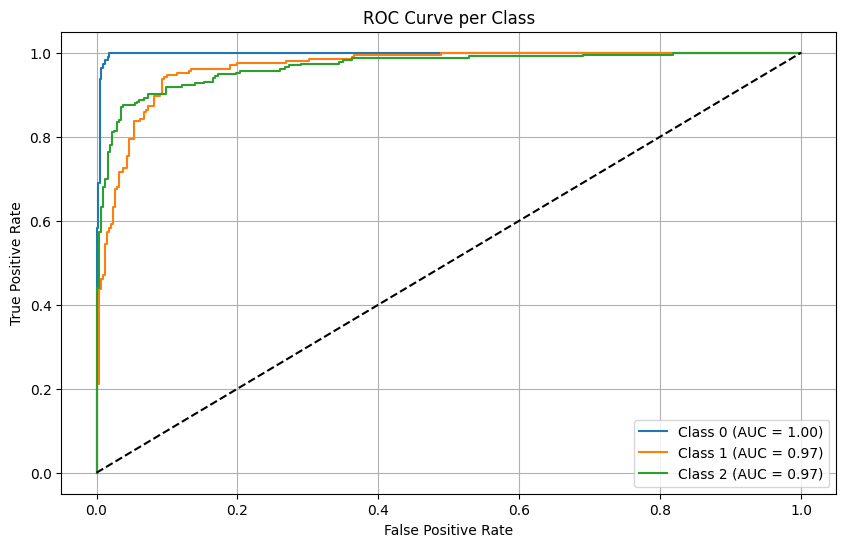


===== FixMatch | Aug: none | Labeled Fraction: 0.8 | Epochs: 5 =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
from itertools import product

# ----- Setup -----
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- Model -----
class SimpleResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = resnet18(pretrained=True)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

# ----- Data Augmentations -----
def get_transforms(aug_type):
    if aug_type == 'strong':
        return T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomResizedCrop(224),
            T.ColorJitter(0.4, 0.4, 0.4, 0.1),
            T.RandomGrayscale(p=0.2),
            T.ToTensor()
        ])
    elif aug_type == 'weak':
        return T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomResizedCrop(224),
            T.ToTensor()
        ])
    else:  # 'none'
        return T.Compose([
            T.Resize((224, 224)),
            T.ToTensor()
        ])

# ----- Data Loaders -----
def get_fixmatch_dataloaders(data_path, batch_size, aug_type='weak', labeled_fraction=0.2, test_size=0.2):
    weak_transform = get_transforms('weak')
    strong_transform = get_transforms('strong')
    base_transform = get_transforms(aug_type)

    full_dataset = ImageFolder(data_path)
    num_classes = len(full_dataset.classes)

    indices = list(range(len(full_dataset)))
    targets = [full_dataset.targets[i] for i in indices]
    train_idx, test_idx = train_test_split(indices, test_size=test_size, stratify=targets)

    split = int(labeled_fraction * len(train_idx))
    random.shuffle(train_idx)
    labeled_idx = train_idx[:split]
    unlabeled_idx = train_idx[split:]

    labeled_dataset = Subset(copy.deepcopy(full_dataset), labeled_idx)
    test_dataset = Subset(copy.deepcopy(full_dataset), test_idx)

    class UnlabeledFixMatch(torch.utils.data.Dataset):
        def __init__(self, dataset):
            self.dataset = dataset
            self.weak_transform = weak_transform
            self.strong_transform = strong_transform

        def __getitem__(self, index):
            x, _ = self.dataset[index]
            return self.weak_transform(x), self.strong_transform(x)

        def __len__(self):
            return len(self.dataset)

    unlabeled_dataset = UnlabeledFixMatch(Subset(copy.deepcopy(full_dataset), unlabeled_idx))

    labeled_dataset.dataset.transform = base_transform
    test_dataset.dataset.transform = get_transforms('none')

    labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return labeled_loader, unlabeled_loader, test_loader, num_classes

# ----- FixMatch Training -----
def train_fixmatch(model, labeled_loader, unlabeled_loader, test_loader, num_classes, epochs=5, lambda_u=1.0, threshold=0.95):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    criterion = nn.CrossEntropyLoss()
    unlabeled_iter = iter(unlabeled_loader)

    for epoch in range(epochs):
        model.train()
        for (x_l, y_l) in labeled_loader:
            try:
                (x_uw, x_us) = next(unlabeled_iter)
            except StopIteration:
                unlabeled_iter = iter(unlabeled_loader)
                (x_uw, x_us) = next(unlabeled_iter)

            x_l, y_l = x_l.to(device), y_l.to(device)
            x_uw, x_us = x_uw.to(device), x_us.to(device)

            # Compute pseudo-labels
            with torch.no_grad():
                logits_uw = model(x_uw)
                probs = torch.softmax(logits_uw, dim=1)
                max_probs, pseudo_labels = torch.max(probs, dim=1)
                mask = max_probs.ge(threshold).float()

            # Supervised loss
            logits_l = model(x_l)
            loss_l = criterion(logits_l, y_l)

            # Unsupervised loss
            logits_us = model(x_us)
            loss_u = (F.cross_entropy(logits_us, pseudo_labels, reduction='none') * mask).mean()

            # Total loss
            loss = loss_l + lambda_u * loss_u

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"[Epoch {epoch+1}] Loss: {loss.item():.4f} (L={loss_l.item():.4f}, U={loss_u.item():.4f})")

    evaluate(model, test_loader, num_classes)

# ----- Evaluation -----
def evaluate(model, dataloader, num_classes):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            logits = model(x)
            probs = torch.softmax(logits, dim=1)
            preds = probs.argmax(dim=1).cpu().numpy()
            y_true.extend(y.numpy())
            y_pred.extend(preds)
            y_prob.extend(probs.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    try:
        roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr')
        print(f"\nROC AUC Score: {roc_auc:.4f}")
    except:
        print("ROC AUC could not be calculated.")

    y_true_bin = np.eye(num_classes)[y_true]
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], np.array(y_prob)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve per Class")
    plt.legend()
    plt.grid()
    plt.show()

# ----- Main Execution -----
if __name__ == '__main__':
    data_path = "/content/gdrive/MyDrive/MS 2nd Semester/AAV data/Images/175 mV/1s_segment_raw/train_val_photos"
    batch_size = 32
    epochs = 5

    augmentations = ['none', 'weak', 'strong']
    fractions = [0.05, 0.1, 0.2, 0.4, 0.6, 0.8]
    combinations = list(product(augmentations, fractions))

    for aug_type, labeled_fraction in combinations:
        print(f"\n===== FixMatch | Aug: {aug_type} | Labeled Fraction: {labeled_fraction} | Epochs: {epochs} =====")
        set_seed(42)
        labeled_loader, unlabeled_loader, test_loader, num_classes = get_fixmatch_dataloaders(
            data_path, batch_size, aug_type, labeled_fraction)
        model = SimpleResNet(num_classes=num_classes)
        train_fixmatch(model, labeled_loader, unlabeled_loader, test_loader, num_classes, epochs=epochs)
